# Read in the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
%matplotlib inline

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations[survey_fields])

DBN                NaN
rr_s          0.232199
rr_t         -0.023386
rr_p          0.047925
N_s           0.423463
N_t           0.291463
N_p           0.421530
saf_p_11      0.122913
com_p_11     -0.115073
eng_p_11      0.020254
aca_p_11      0.035155
saf_t_11      0.313810
com_t_11      0.082419
eng_t_11      0.036906
aca_t_11      0.132348
saf_s_11      0.337639
com_s_11      0.187370
eng_s_11      0.213822
aca_s_11      0.339435
saf_tot_11    0.318753
com_tot_11    0.077310
eng_tot_11    0.100102
aca_tot_11    0.190966
Name: sat_score, dtype: float64


/dataquest/system/env/python3/lib/python3.4/site-packages/pandas/core/series.py:705: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

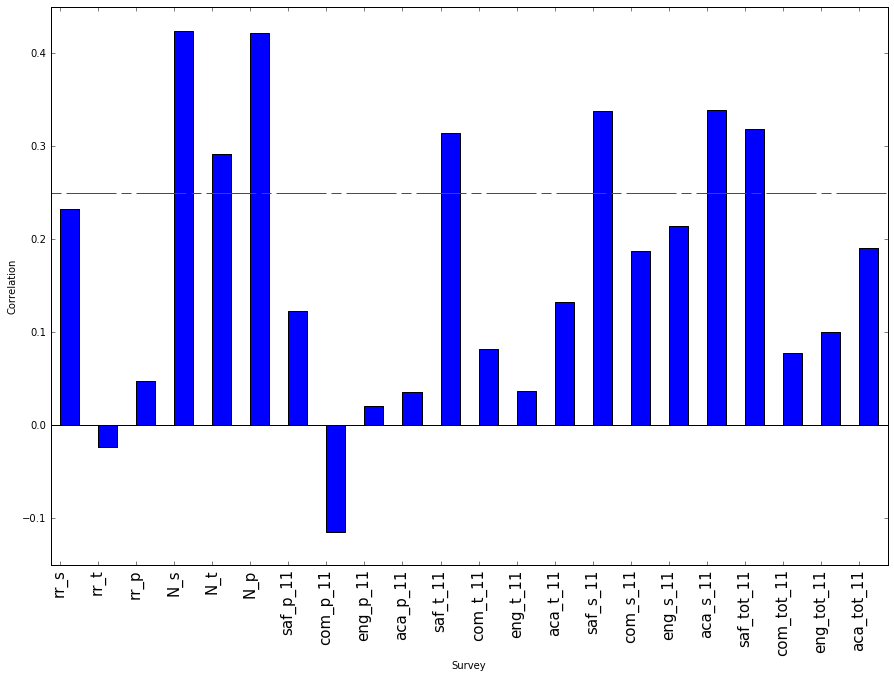

In [11]:
fig, ax= plt.subplots(figsize=(15,10))
ax.bar(np.arange(correlations[survey_fields].shape[0])+.5,correlations[survey_fields],width=0.5,align='center')
ax.set_xticks(np.arange(correlations[survey_fields].shape[0]) + .5 / 2)
ax.set_xticklabels(survey_fields,rotation=90,fontsize=15)
ax.set_ylabel('Correlation')
ax.set_ylim(-.15,.45)
ax.set_xlim(0,22)
ax.set_xlabel('Survey')
ax.axhline(y=0,c='Black')
dashes = [10, 5, 50, 5]
l1 = ax.axhline(y=0.25,c='Red',dashes='on')
l1.set_dashes(dashes)
plt.show()

The data shows strong correlation (above 0.25) for the following categories:

N_s,N_t,N_p:  relating to the number of students responding to the survey<br>
saf_t_11,p_11,s_11:  relating to the safety and respect score given by the students, teachers and parents <br>
aca_s_11:  relating to the student's academic expectations.

It's not surprising that students with higher academic expectations will get highter sat scores nor that students/teachers/parents that feel safer will also score better.  However, it is interesting that the # of responses correlates the highest with sat scores.  I suppose that it has an indirect correlation with involvement.


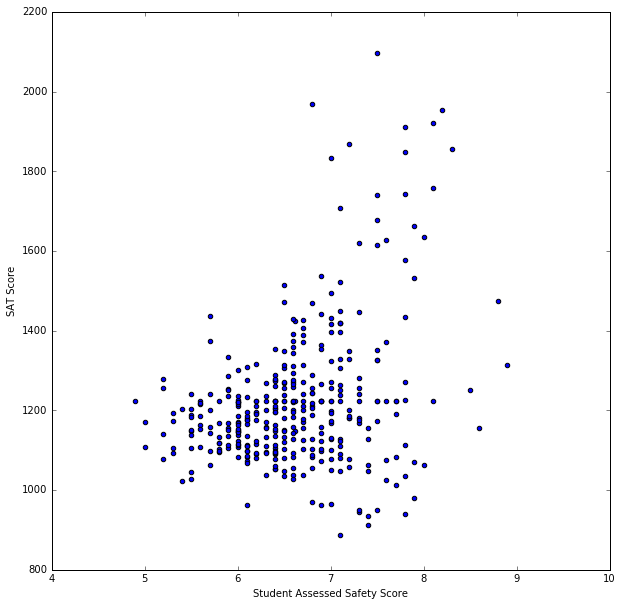

In [12]:
fig = plt.figure(figsize=(10,10))

plt.scatter(combined['saf_s_11'],combined['sat_score'])
plt.xlabel('Student Assessed Safety Score')
plt.ylabel('SAT Score')
plt.show()

While the correlation is not extreme, one instantly notices that all the schools with safety scores below 6 have SAT scores less than 1400 and those with SAT scores above 1600 are between 7-8.

In [13]:
sftyscre = combined.groupby('school_dist').agg(np.mean)
sftyscre.reset_index('school_dist',inplace=True)
sftyscre[['school_dist','saf_s_11','sat_score']][:5]

,school_dist,saf_s_11,sat_score
0,01,6.768611,1354.500000
1,02,6.910660,1295.638184
2,03,6.716667,1293.443035
3,04,6.885714,1224.142857
4,05,6.314286,1285.062687


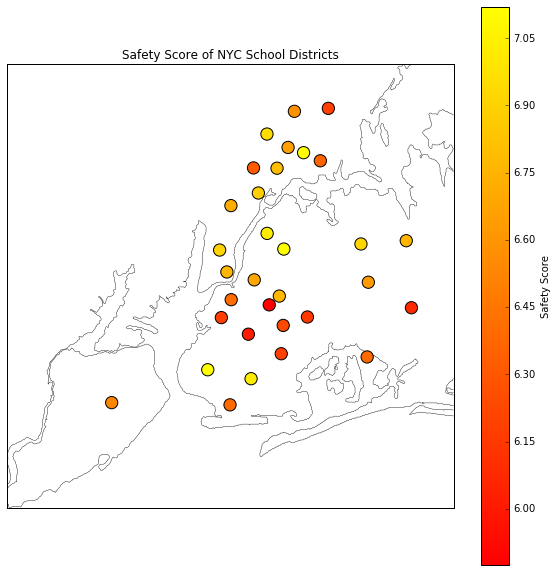

In [14]:
from mpl_toolkits.basemap import Basemap

fig = plt.figure(figsize=(10,10))
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='f'
)

m.drawmapboundary(fill_color='#ffffff')
m.drawcoastlines(color='#000000', linewidth=.4)
m.drawrivers(color='#424b4f', linewidth=.4)

longitudes = sftyscre.lon.tolist()
latitudes = sftyscre.lat.tolist()

a = m.scatter(longitudes,latitudes,s=150,zorder=2,latlon=True,c=sftyscre['saf_s_11'],cmap='autumn')
cbar = plt.colorbar(a)
cbar.ax.set_ylabel('Safety Score', rotation=90)
plt.title('Safety Score of NYC School Districts')
plt.show()

In general the saftey score seems to decrease the further you get away from manhattan, and in particular things get dangerous in south brooklyn.

# Racial Breakdown of SAT Performance

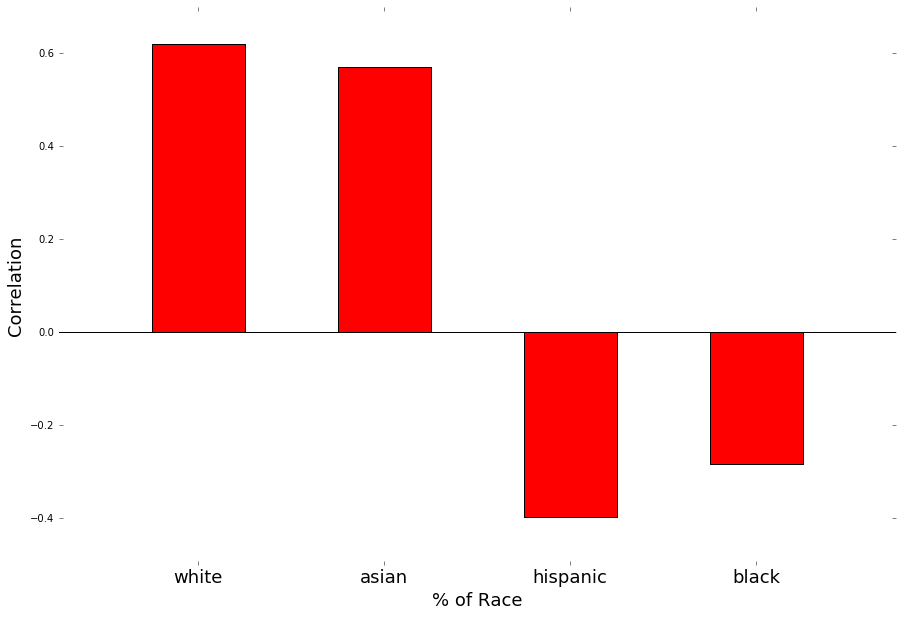

In [15]:
rcs = ['white_per','asian_per','hispanic_per','black_per']
correlations = combined.corr()
correlations = correlations["sat_score"]
correlations.index

fig1,ax1 = plt.subplots(figsize=(15,10))
rindex = np.arange(4)
ax1.bar(rindex,correlations[rcs],width=.5,color='red')
ax1.set_xticks(rindex+.5/2)
ax1.set_xticklabels(['white','asian','hispanic','black'],fontsize=18)
ax1.set_ylabel('Correlation',fontsize=18)
ax1.set_ylim(-.5,.7)
ax1.set_xlim(-.5,4)
ax1.set_xlabel('% of Race',fontsize=18)
ax1.axhline(y=0,c='Black')
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)
plt.show()

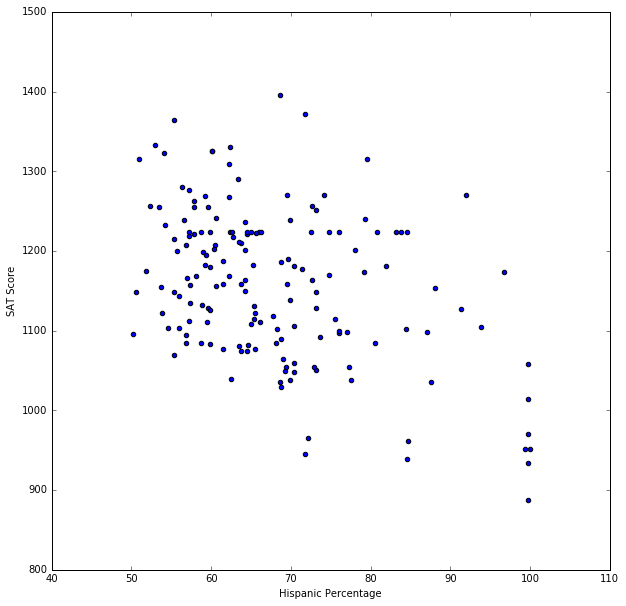

In [16]:
#low SAT, high hispanic filter
lshh = (combined['hispanic_per']>50)&(combined['sat_score']<1400)

fig2= plt.figure(figsize=(10,10))

ax1 = fig2.add_subplot(1,1,1)
ax1.scatter(combined.loc[lshh,'hispanic_per'],combined.loc[lshh,'sat_score'])
ax1.set_xlabel('Hispanic Percentage')
ax1.set_ylabel('SAT Score')
plt.show()

In [17]:
#high hispanic filter
highhispanic = combined[combined['hispanic_per']>95]
highhispanic['SCHOOL NAME'][:]

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

    These schools tend to be ESL

In [18]:
#high hispanic filter
highhispanic = combined[(combined['hispanic_per']<10)&(combined['sat_score']<1800)]
highhispanic['SCHOOL NAME'][:]

46       HIGH SCHOOL FOR DUAL LANGUAGE AND ASIAN STUDIES
192                          BEDFORD ACADEMY HIGH SCHOOL
194                            BENJAMIN BANNEKER ACADEMY
220                           BOYS AND GIRLS HIGH SCHOOL
223    ACADEMY FOR COLLEGE PREPARATION AND CAREER EXP...
226               THE HIGH SCHOOL FOR GLOBAL CITIZENSHIP
227                         SCHOOL FOR HUMAN RIGHTS, THE
228                  SCHOOL FOR DEMOCRACY AND LEADERSHIP
229    HIGH SCHOOL FOR YOUTH AND COMMUNITY DEVELOPMEN...
230        HIGH SCHOOL FOR SERVICE & LEARNING AT ERASMUS
231    SCIENCE, TECHNOLOGY AND RESEARCH EARLY COLLEGE...
235              MEDGAR EVERS COLLEGE PREPARATORY SCHOOL
236                             CLARA BARTON HIGH SCHOOL
237                           IT TAKES A VILLAGE ACADEMY
238                           BROOKLYN GENERATION SCHOOL
240              KURT HAHN EXPEDITIONARY LEARNING SCHOOL
241                       VICTORY COLLEGIATE HIGH SCHOOL
242                     ARTS & 

Appear to be a high number of academys and specialised schools

# Sex/Gender and the SAT

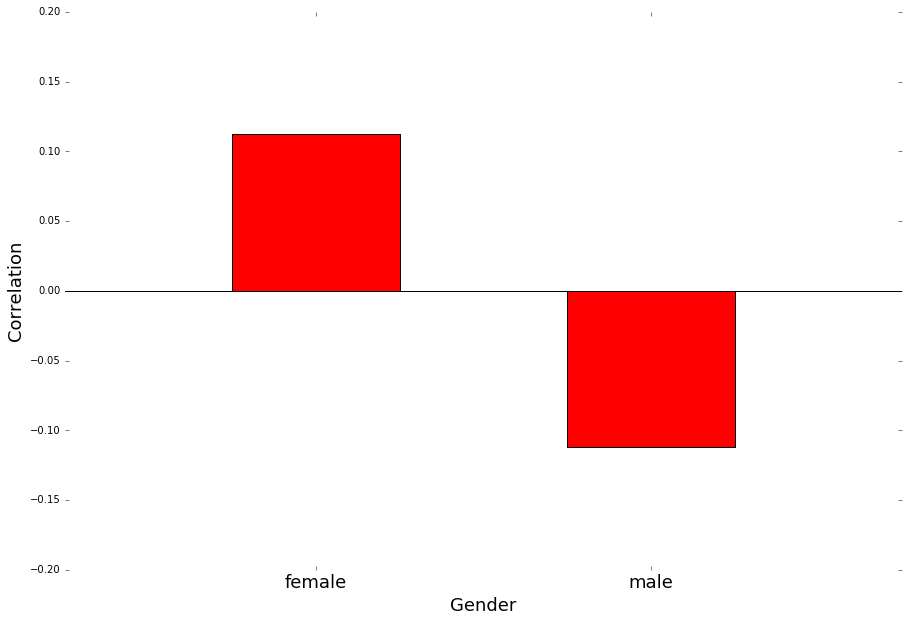

In [24]:
rcs = ['female_per','male_per']
correlations = combined.corr()
correlations = correlations["sat_score"]
correlations.index

fig2,ax2 = plt.subplots(figsize=(15,10))
rindex = np.arange(2)
ax2.bar(rindex,correlations[rcs],width=.5,color='red')
ax2.set_xticks(rindex+.5/2)
ax2.set_xticklabels(['female','male'],fontsize=18)
ax2.set_ylabel('Correlation',fontsize=18)
ax2.set_ylim(-.2,.2)
ax2.set_xlim(-.5,2)
ax2.set_xlabel('Gender',fontsize=18)
ax2.axhline(y=0,c='Black')
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
plt.show()

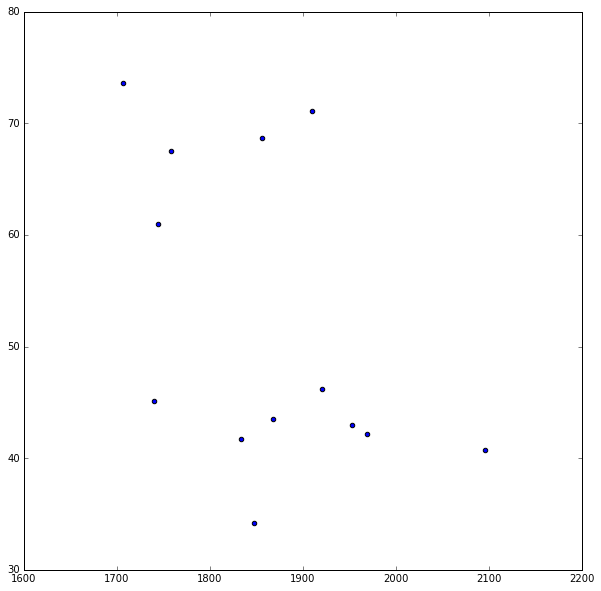

In [30]:
fig3 = plt.figure(figsize=(10,10))
plt.scatter(combined.loc[combined['sat_score']>1700,'sat_score'],combined.loc[combined['sat_score']>1700,'female_per'])
plt.show()

In [32]:
combined.loc[(combined['sat_score']>1700) & (combined['female_per']>60)]

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624.0,604.0,628.0,1856.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"525 East Houston Street\nNew York, NY 10002\n(...",40.718962,-73.976066,01
26,02M416,ELEANOR ROOSEVELT HIGH SCHOOL,127,572.0,594.0,592.0,1758.0,Eleanor Roosevelt High School,155.000000,235.000000,...,0,0,0,0,0,0,"411 East 76 Street\nNew York, NY 10021\n(40.77...",40.770116,-73.953379,02
60,03M479,BEACON HIGH SCHOOL,261,577.0,575.0,592.0,1744.0,BEACON SCHOOL,166.000000,197.000000,...,0,0,0,0,0,0,"227-243 West 61St Street\nNew York, NY 10023\n...",40.772158,-73.987797,03
61,03M485,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,531,566.0,564.0,577.0,1707.0,FIORELLO H.LAGUARDIA HS,691.000000,1236.000000,...,0,0,0,0,0,0,"100 Amsterdam Avenue\nNew York, NY 10023\n(40....",40.773671,-73.985269,03
302,25Q525,TOWNSEND HARRIS HIGH SCHOOL,278,621.0,651.0,638.0,1910.0,TOWNSEND HARRIS HS,613.000000,796.000000,...,0,0,0,0,0,0,"149-11 Melbourne Avenue\nFlushing, NY 11367\n(...",40.734408,-73.821417,25


In [33]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']

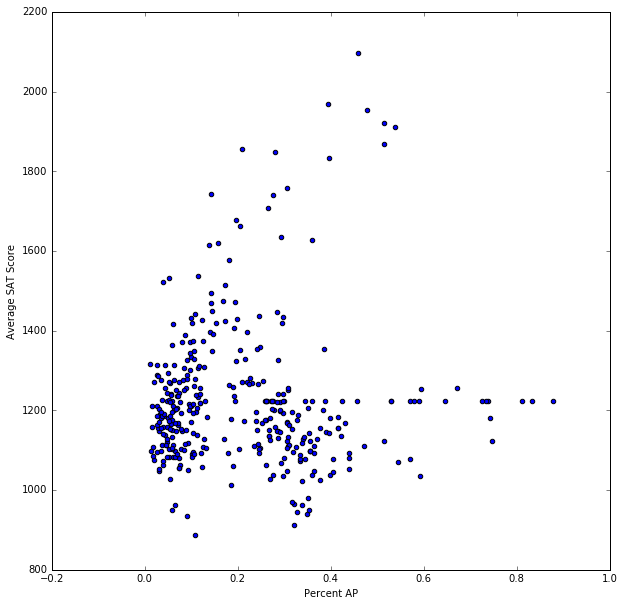

In [35]:
fig4 = plt.figure(figsize=(10,10))
plt.scatter(combined['ap_per'],combined['sat_score'])
plt.xlabel('Percent AP')
plt.ylabel('Average SAT Score')
plt.show()

Two Populations.  One which appears to see a very linear relationship between the % AP test takers and the sat scores and the other appears to be pretty flat

# Average SAT Score by school district


In [42]:
satscores = combined[['lat','lon','sat_score','school_dist']].groupby('school_dist').agg(np.mean)
satscores.reset_index('school_dist',inplace=True)

In [ ]:
from mpl_toolkits.basemap import Basemap

fig = plt.figure(figsize=(10,10))
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='f'
)

m.drawmapboundary(fill_color='#ffffff')
m.drawcoastlines(color='#000000', linewidth=.4)
m.drawrivers(color='#424b4f', linewidth=.4)

longitudes = satscores.lon.tolist()
latitudes = satscores.lat.tolist()

a = m.scatter(combined['lon'].tolist(),combined['lat'].tolist(),s=50,zorder=2,latlon=True,c=combined['sat_score'],cmap='seismic')
cbar = plt.colorbar(a)
cbar.ax.set_ylabel('SAT Score', rotation=90)
plt.title('SAT Score by NYC School')
plt.show()